<h2>The Battle of the Neighborhoods - Week 2 - Final</h2>

<h3>Import Libraries</h3>
In this section we will import the required libraries.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

import folium

<h4>Download and Read Dataset</h4>
We can find information about the districts of the city of Madrid in the following link:

http://www.madrid.org/iestadis/fijas/clasificaciones/descarga/cobar18.xls

In [2]:
df_all_madrid = pd.read_excel('http://www.madrid.org/iestadis/fijas/clasificaciones/descarga/cobar18.xls', index_col=0)  

In [3]:
df_all_madrid.head()

,distr,ldistr,barrio,descrip,secci
munic,,,,,
796,1,Centro,1,Palacio,1
796,1,Centro,1,Palacio,2
796,1,Centro,1,Palacio,3
796,1,Centro,1,Palacio,4
796,1,Centro,1,Palacio,6


In this list there are several rows for each neighborhood, therefore, we will first obtain a list with the unique values of each neighborhood.

In [4]:
df_all_madrid.drop_duplicates(subset ="descrip", keep = "first", inplace = True)

In [5]:
df_all_madrid.shape
df_all_madrid.head()

,distr,ldistr,barrio,descrip,secci
munic,,,,,
796,1,Centro,1,Palacio,1
796,1,Centro,2,Embajadores,22
796,1,Centro,3,Cortes,61
796,1,Centro,4,Justicia,73
796,1,Centro,5,Universidad,90


<h4>We have 131 neighborhoods within the city of Madrid</h4>
So, we'll just stick to the list of neighborhoods:

In [6]:
df_all_madrid = df_all_madrid.reset_index(drop=True)
df_all_madrid.drop(['distr', 'ldistr', 'barrio', 'secci'], axis=1, inplace=True)
df_all_madrid.head()

,descrip
0,Palacio
1,Embajadores
2,Cortes
3,Justicia
4,Universidad


In [7]:
df_all_madrid.rename(columns={"descrip": "Neighborhood"}, inplace=True)
df_all_madrid.head()

,Neighborhood
0,Palacio
1,Embajadores
2,Cortes
3,Justicia
4,Universidad


<h4>Ready, a list of all the neighborhoods in the city</h4>
Now, we need the latitude and longitude values of each neighborhood. For this we have been able to obtain a file from the Town Hall by mail which is kept locally.

In [8]:
df_coord = pd.read_excel('C:\\AA-Coursera\\09 - Applied Data Science Capstone\\Madrid\\CALLEJERO_VIGENTE_BARRIOS.xlsx') 
df_coord.head()

,BARRIOS,LATITUD,LONGITUD
0,Abrantes,40.380556,-3.723889
1,Acacias,40.401422,-3.704936
2,Adelfas,40.400278,-3.670833
3,Aeropuerto,40.494167,-3.566944
4,Alameda de Osuna,40.457222,-3.587778


At this point, having received the list from the town hall, the first file is not necessary as the names are the same.

In [9]:
df = df_coord.rename(columns={"BARRIOS": "Neighborhood", "LATITUD": "Latitud" , "LONGITUD": "Longitud"})
df.head()

,Neighborhood,Latitud,Longitud
0,Abrantes,40.380556,-3.723889
1,Acacias,40.401422,-3.704936
2,Adelfas,40.400278,-3.670833
3,Aeropuerto,40.494167,-3.566944
4,Alameda de Osuna,40.457222,-3.587778


<h4>Get Latitude and Longitude of Madrid</h4>

In [10]:
address = 'Madrid'

geolocator = Nominatim(user_agent="madrid_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid City are 40.4167047, -3.7035825.


<h4>Create a Map of Madrid</h4>

In [11]:
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(df['Latitud'], df['Longitud'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

<h4>Foursquare Venues Function</h4>

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [16]:
# Foursquare ID & SECRET
LIMIT = 500 
radius = 2000 
CLIENT_ID = 'KI3TR0QO4JOKMFELOMF3WSOOI3HFNBF5YLW354MYWBKDHEX3' 
CLIENT_SECRET = 'QF4ZBLJRBV4BQX52DVWUPEHJ14A2UJABPCZARZQZYTKIISUD'
VERSION = '20181206'

In our case, we can select only the data that corresponds to vegan restaurants by searching for the category in the foursquare developer section.
https://developer.foursquare.com/docs/build-with-foursquare/categories/
Vegetarian / Vegan Restaurant
4bf58dd8d48988d1d3941735

In [18]:
madrid_venues_vegan = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitud'], longitudes=df['Longitud'], radius=1000, categoryIds='4bf58dd8d48988d1d3941735')
madrid_venues_vegan.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acacias,40.401422,-3.704936,Distrito Vegano,40.406972,-3.699679,Vegetarian / Vegan Restaurant
1,Acacias,40.401422,-3.704936,La Tia Carlota,40.407516,-3.699776,Vegetarian / Vegan Restaurant
2,Acacias,40.401422,-3.704936,la oveja negra,40.409322,-3.699811,Vegetarian / Vegan Restaurant
3,Acacias,40.401422,-3.704936,Yatiri,40.412690,-3.703373,Vegetarian / Vegan Restaurant
4,Acacias,40.401422,-3.704936,El Granero,40.408275,-3.697631,Vegetarian / Vegan Restaurant


In [19]:
madrid_venues_vegan.shape

(587, 7)

We have 587 records of vegan restaurants throughout the city of Madrid.

In [20]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

<h4>Let's see a first impression of the distribution of the restaurants.</h4>

In [21]:
map_madrid_vegan = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(madrid_venues_vegan, 'blue', map_madrid_vegan)

map_madrid_vegan

In [22]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

<h4>Let's check how many vegan restaurants there are in each neighborhood.</h4>

In [23]:
madrid_grouped = madrid_venues_vegan.groupby('Neighborhood').count()
madrid_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acacias,8,8,8,8,8,8
Adelfas,3,3,3,3,3,3
Almagro,28,28,28,28,28,28
Almenara,1,1,1,1,1,1
Aluche,1,1,1,1,1,1
Arapiles,29,29,29,29,29,29
Argüelles,18,18,18,18,18,18
Atocha,2,2,2,2,2,2
Bellas Vistas,4,4,4,4,4,4


<h4>Analyze Each Neighborhood</h4>

In [24]:
# One hot encoding
madrid_onehot = pd.get_dummies(madrid_venues_vegan[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_venues_vegan['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

,Neighborhood,Café,Deli / Bodega,Donut Shop,Fast Food Restaurant,Gluten-free Restaurant,Gym / Fitness Center,Indian Restaurant,Organic Grocery,Pizza Place,Salad Place,Sandwich Place,Spanish Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Acacias,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Acacias,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Acacias,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Acacias,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Acacias,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,Café,Deli / Bodega,Donut Shop,Fast Food Restaurant,Gluten-free Restaurant,Gym / Fitness Center,Indian Restaurant,Organic Grocery,Pizza Place,Salad Place,Sandwich Place,Spanish Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Acacias,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,Adelfas,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,Almagro,0.000000,0.035714,0.000000,0.035714,0.000000,0.00,0.035714,0.035714,0.035714,0.000000,0.000000,0.071429,0.000000,0.750000
3,Almenara,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,Aluche,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,Arapiles,0.000000,0.034483,0.034483,0.034483,0.000000,0.00,0.000000,0.000000,0.034483,0.000000,0.000000,0.034483,0.000000,0.827586
6,Argüelles,0.000000,0.000000,0.055556,0.000000,0.000000,0.00,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.888889
7,Atocha,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,Bellas Vistas,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
9,Berruguete,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<h4>Let's now review the most common categories by neighborhood that include vegan food.</h4>

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacias,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
1,Adelfas,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
2,Almagro,Vegetarian / Vegan Restaurant,Spanish Restaurant,Pizza Place,Organic Grocery,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place
3,Almenara,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
4,Aluche,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant


<h4>Cluster Neighborhoods</h4>

In [28]:
# Set number of clusters
kclusters = 4

madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 0, 2, 2, 3, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 3, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = df
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

madrid_merged

,Neighborhood,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrantes,40.380556,-3.723889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acacias,40.401422,-3.704936,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
2,Adelfas,40.400278,-3.670833,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
3,Aeropuerto,40.494167,-3.566944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alameda de Osuna,40.457222,-3.587778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Almagro,40.431667,-3.694167,0.0,Vegetarian / Vegan Restaurant,Spanish Restaurant,Pizza Place,Organic Grocery,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place
6,Almenara,40.471290,-3.695505,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
7,Almendrales,40.383611,-3.698889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Aluche,40.387500,-3.754167,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
9,Amposta,40.430278,-3.619444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see, there are several neighborhoods that do not have any restaurant of this type, they are periferical neighborhoods, in this study we will not include them.

In [30]:
madrid_merged.dropna(subset=['Cluster Labels'], inplace=True)

In [31]:
madrid_merged

,Neighborhood,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acacias,40.401422,-3.704936,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
2,Adelfas,40.400278,-3.670833,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
5,Almagro,40.431667,-3.694167,0.0,Vegetarian / Vegan Restaurant,Spanish Restaurant,Pizza Place,Organic Grocery,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place
6,Almenara,40.471290,-3.695505,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
8,Aluche,40.387500,-3.754167,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
11,Arapiles,40.434167,-3.707778,0.0,Vegetarian / Vegan Restaurant,Spanish Restaurant,Pizza Place,Fast Food Restaurant,Donut Shop,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place,Organic Grocery
14,Argüelles,40.429161,-3.718847,0.0,Vegetarian / Vegan Restaurant,Organic Grocery,Donut Shop,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Indian Restaurant,Gym / Fitness Center
16,Atocha,40.400278,-3.683056,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
17,Bellas Vistas,40.452458,-3.707190,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
18,Berruguete,40.457500,-3.705556,0.0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant


In [32]:
madrid_merged['Cluster Labels'] = madrid_merged['Cluster Labels'].astype(np.int64)

In [33]:
madrid_merged.head()

,Neighborhood,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acacias,40.401422,-3.704936,0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
2,Adelfas,40.400278,-3.670833,0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
5,Almagro,40.431667,-3.694167,0,Vegetarian / Vegan Restaurant,Spanish Restaurant,Pizza Place,Organic Grocery,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place
6,Almenara,40.471290,-3.695505,0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
8,Aluche,40.387500,-3.754167,0,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant


In [34]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitud'], madrid_merged['Longitud'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

<h4>Clusters analysis</h4>

<h2>Cluster 0</h2>

In [35]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0,
                  madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Latitud,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,40.401422,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
2,40.400278,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
5,40.431667,Spanish Restaurant,Pizza Place,Organic Grocery,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place
6,40.471290,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
8,40.387500,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
11,40.434167,Spanish Restaurant,Pizza Place,Fast Food Restaurant,Donut Shop,Deli / Bodega,Thai Restaurant,Sandwich Place,Salad Place,Organic Grocery
14,40.429161,Organic Grocery,Donut Shop,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Indian Restaurant,Gym / Fitness Center
16,40.400278,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
17,40.452458,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
18,40.457500,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant


<h2>Cluster 1</h2>

In [36]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1,
                     madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Latitud,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,40.478228,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
66,40.481389,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
77,40.491667,Vegetarian / Vegan Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant


<h2>Cluster 2</h2>

In [37]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2,
                     madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Latitud,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,40.432806,Indian Restaurant,Spanish Restaurant,Organic Grocery,Thai Restaurant,Sandwich Place,Salad Place,Pizza Place,Gym / Fitness Center,Gluten-free Restaurant
32,40.446944,Indian Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Gym / Fitness Center,Gluten-free Restaurant
55,40.424722,Salad Place,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Organic Grocery,Indian Restaurant,Gym / Fitness Center,Gluten-free Restaurant
58,40.424722,Salad Place,Organic Grocery,Indian Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Gym / Fitness Center,Gluten-free Restaurant
59,40.436169,Indian Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Gym / Fitness Center,Gluten-free Restaurant
63,40.418889,Salad Place,Indian Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Organic Grocery,Gym / Fitness Center,Gluten-free Restaurant
69,40.432778,Indian Restaurant,Salad Place,Organic Grocery,Thai Restaurant,Spanish Restaurant,Sandwich Place,Pizza Place,Gym / Fitness Center,Gluten-free Restaurant
97,40.445000,Indian Restaurant,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Gym / Fitness Center,Gluten-free Restaurant


<h2>Cluster 3</h2>

In [38]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3,
                     madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Latitud,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,40.455556,Gym / Fitness Center,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gluten-free Restaurant
80,40.463056,Gym / Fitness Center,Thai Restaurant,Spanish Restaurant,Sandwich Place,Salad Place,Pizza Place,Organic Grocery,Indian Restaurant,Gluten-free Restaurant


At this point we don't have a clear picture yet. Let's go back to the number of vegan sites by neighborhood.

In [91]:
madrid_all_vegan = madrid_venues_vegan.groupby('Neighborhood').count()

In [92]:
madrid_all_vegan.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acacias,8,8,8,8,8,8
Adelfas,3,3,3,3,3,3
Almagro,28,28,28,28,28,28
Almenara,1,1,1,1,1,1
Aluche,1,1,1,1,1,1


In [93]:
madrid_all_vegan.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)

In [94]:
madrid_all_vegan.head()

,Venue
Neighborhood,
Acacias,8
Adelfas,3
Almagro,28
Almenara,1
Aluche,1


In [95]:
#madrid_all_vegan = madrid_all_vegan.reset_index()
madrid_all_vegan

,Venue
Neighborhood,
Acacias,8
Adelfas,3
Almagro,28
Almenara,1
Aluche,1
Arapiles,29
Argüelles,18
Atocha,2
Bellas Vistas,4


In [44]:
madrid_all_vegan.shape

(62, 2)

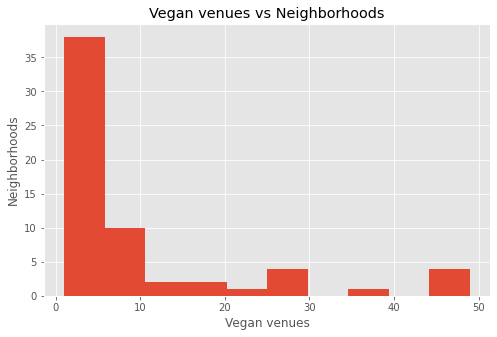

In [130]:
madrid_all_vegan['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Vegan venues vs Neighborhoods')
plt.ylabel('Neighborhoods')
plt.xlabel('Vegan venues')
plt.show()

As you can see, most of the neighborhoods have very few vegan sites, this is very good. On the other hand, a minority concentrates the largest number of sites (over 30). The downtown neighborhoods, of course.

In [46]:
df.head()

,Neighborhood,Latitud,Longitud
0,Abrantes,40.380556,-3.723889
1,Acacias,40.401422,-3.704936
2,Adelfas,40.400278,-3.670833
3,Aeropuerto,40.494167,-3.566944
4,Alameda de Osuna,40.457222,-3.587778


Let's try to confirm this, let's take as an indicator of the popularity of a neighborhood the number of sites in it, without filters.

In [48]:
madrid_venues_all = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitud'], longitudes=df['Longitud'], radius=1000, categoryIds='4d4b7105d754a06374d81259')
madrid_venues_all.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abrantes,40.380556,-3.723889,Churrascaria Baby Beef,40.383180,-3.720789,Brazilian Restaurant
1,Abrantes,40.380556,-3.723889,Chow Fan,40.386781,-3.730639,Chinese Restaurant
2,Abrantes,40.380556,-3.723889,Döner Kebap Nemrut,40.388257,-3.730849,Kebab Restaurant
3,Abrantes,40.380556,-3.723889,American Ribs,40.387412,-3.718623,American Restaurant
4,Abrantes,40.380556,-3.723889,heladería Tino,40.381757,-3.730576,Ice Cream Shop


In [57]:
madrid_venues_all.shape

(5809, 7)

In [58]:
madrid_grouped_all = madrid_venues_all.groupby('Neighborhood').count()
madrid_grouped_all

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abrantes,47,47,47,47,47,47
Acacias,47,47,47,47,47,47
Adelfas,48,48,48,48,48,48
Aeropuerto,27,27,27,27,27,27
Alameda de Osuna,48,48,48,48,48,48
Almagro,50,50,50,50,50,50
Almenara,50,50,50,50,50,50
Almendrales,47,47,47,47,47,47
Aluche,47,47,47,47,47,47


In [59]:
madrid_grouped_all.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)

In [60]:
madrid_grouped_all.head()

,Venue
Neighborhood,
Abrantes,47
Acacias,47
Adelfas,48
Aeropuerto,27
Alameda de Osuna,48


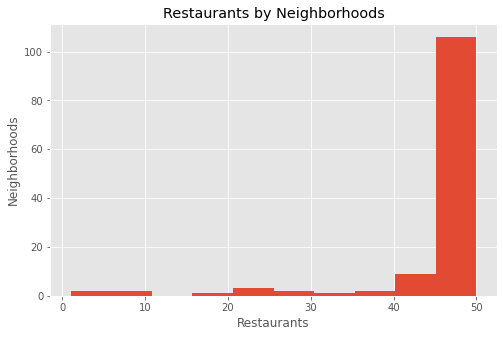

In [131]:
madrid_grouped_all['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Restaurants by Neighborhoods')
plt.ylabel('Neighborhoods')
plt.xlabel('Restaurants')
plt.show()

As you can see the restaurants are very common places in Madrid, practically all the neighborhoods have between 45 and 50 places of this type.

Let's try the colleges.

In [68]:
madrid_venues_all = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitud'], longitudes=df['Longitud'], radius=1000, categoryIds='4d4b7105d754a06372d81259')
madrid_venues_all.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abrantes,40.380556,-3.723889,Escuela Federacion Futbol Madrid . Campo Ernes...,40.380805,-3.723428,Athletics & Sports
1,Abrantes,40.380556,-3.723889,Colegio Santa Beatriz De Silva,40.380040,-3.728919,General College & University
2,Abrantes,40.380556,-3.723889,Academia Fire School,40.391273,-3.723207,College Gym
3,Abrantes,40.380556,-3.723889,Escuela Oficial de Idiomas Carabanchel,40.385878,-3.721144,Student Center
4,Abrantes,40.380556,-3.723889,Residencia de estudiantes San Fernando,40.386131,-3.735278,College Residence Hall


In [69]:
madrid_univ = madrid_venues_all.groupby('Neighborhood').count()
madrid_univ

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abrantes,15,15,15,15,15,15
Acacias,48,48,48,48,48,48
Adelfas,45,45,45,45,45,45
Alameda de Osuna,9,9,9,9,9,9
Almagro,47,47,47,47,47,47
Almenara,45,45,45,45,45,45
Almendrales,24,24,24,24,24,24
Aluche,24,24,24,24,24,24
Amposta,48,48,48,48,48,48


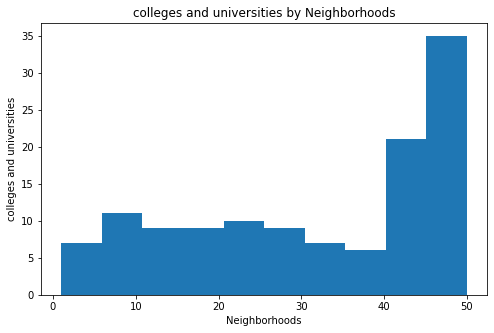

In [71]:
madrid_univ['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('colleges and universities by Neighborhoods')
plt.ylabel('colleges and universities')
plt.xlabel('Neighborhoods')
plt.show()

In [78]:
madrid_univ = madrid_univ[madrid_univ.Venue > 45]
madrid_univ

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acacias,48,48,48,48,48,48
Almagro,47,47,47,47,47,47
Amposta,48,48,48,48,48,48
Arapiles,46,46,46,46,46,46
Argüelles,48,48,48,48,48,48
Atalaya,49,49,49,49,49,49
Bellas Vistas,47,47,47,47,47,47
Berruguete,49,49,49,49,49,49
Castellana,50,50,50,50,50,50


In [79]:
madrid_univ.shape

(35, 6)

In [80]:
madrid_univ.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)

In [81]:
madrid_univ.head()

,Venue
Neighborhood,
Acacias,48
Almagro,47
Amposta,48
Arapiles,46
Argüelles,48


In [83]:
madrid_univ = madrid_univ.rename(columns={"Venue": "Universities"})
madrid_univ

,Universities
Neighborhood,
Acacias,48
Almagro,47
Amposta,48
Arapiles,46
Argüelles,48
Atalaya,49
Bellas Vistas,47
Berruguete,49
Castellana,50


In [96]:
madrid_all_vegan

,Venue
Neighborhood,
Acacias,8
Adelfas,3
Almagro,28
Almenara,1
Aluche,1
Arapiles,29
Argüelles,18
Atocha,2
Bellas Vistas,4


In [99]:
madrid_set = madrid_univ.join(madrid_all_vegan)

In [100]:
madrid_set

,Universities,Venue
Neighborhood,,
Acacias,48,8.0
Almagro,47,28.0
Amposta,48,NaN
Arapiles,46,29.0
Argüelles,48,18.0
Atalaya,49,NaN
Bellas Vistas,47,4.0
Berruguete,49,3.0
Castellana,50,10.0


In [101]:
madrid_finalists = madrid_set[madrid_set['Venue'].isnull()]

In [102]:
madrid_finalists

,Universities,Venue
Neighborhood,,
Amposta,48,NaN
Atalaya,49,NaN
Chopera,46,NaN
Colina,49,NaN
Horcajo,46,NaN
San Juan Bautista,48,NaN


Here are the finalists for the poster, the first Vegan in the neighborhood. Areas with high student movement and no vegan options.

We are going to try to decide for one, in the Web of the Community of Madrid statistical files can be configured to unload, we are going to look for the evolution of population of these districts and we will stay with the greater projection of growth.
http://www-2.munimadrid.es/TSE6/control/seleccionDatosBarrio

In [122]:
madrid_final_grow = pd.read_excel('C:\\AA-Coursera\\09 - Applied Data Science Capstone\\Madrid\\BARRIOS_FILTRO_1.xlsx') 
madrid_final_grow

,BARRIO,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Amposta,6439,6984,7122,7223,7184,7098,6872,6954,7023,7273,7301,7298,7435,7689,7851,7997,8284,8342,8471,8532
1,Atalaya,768,801,826,899,961,981,1076,1193,1268,1275,1325,1376,1498,1503,1501,1537,1559,1654,1699,1570
2,Chopera,14237,15432,16065,16707,17451,17948,18237,18399,18358,18139,17645,17091,17345,17110,16851,16759,16500,16333,16420,16340
3,Colina,6003,5879,6098,6138,6087,6174,6272,6235,6337,6396,6387,6410,6476,6538,6510,6598,6671,6601,6700,6754
4,Horcajo,10891,10900,11341,11204,11705,11975,12276,12585,12457,12594,13173,13001,13164,13299,13438,13659,13971,14199,14201,14321
5,San Juan Bautista,3487,3386,3399,3122,3451,3684,3755,3899,4052,4332,4798,5016,5129,5238,5387,5487,5591,5688,5677,5643


Let's see visually how each of these neighborhoods is doing.

In [123]:
madrid_final_grow.shape

(6, 21)

In [124]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('ggplot')

In [125]:
years = list(map(str, range(2000, 2020)))
years

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [126]:
madrid_final_grow.set_index('BARRIO', inplace=True)
madrid_final_grow

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
BARRIO,,,,,,,,,,,,,,,,,,,,
Amposta,6439,6984,7122,7223,7184,7098,6872,6954,7023,7273,7301,7298,7435,7689,7851,7997,8284,8342,8471,8532
Atalaya,768,801,826,899,961,981,1076,1193,1268,1275,1325,1376,1498,1503,1501,1537,1559,1654,1699,1570
Chopera,14237,15432,16065,16707,17451,17948,18237,18399,18358,18139,17645,17091,17345,17110,16851,16759,16500,16333,16420,16340
Colina,6003,5879,6098,6138,6087,6174,6272,6235,6337,6396,6387,6410,6476,6538,6510,6598,6671,6601,6700,6754
Horcajo,10891,10900,11341,11204,11705,11975,12276,12585,12457,12594,13173,13001,13164,13299,13438,13659,13971,14199,14201,14321
San Juan Bautista,3487,3386,3399,3122,3451,3684,3755,3899,4052,4332,4798,5016,5129,5238,5387,5487,5591,5688,5677,5643


In [127]:
madrid_final_grow = madrid_final_grow.transpose()
madrid_final_grow

BARRIO,Amposta,Atalaya,Chopera,Colina,Horcajo,San Juan Bautista
2000,6439,768,14237,6003,10891,3487
2001,6984,801,15432,5879,10900,3386
2002,7122,826,16065,6098,11341,3399
2003,7223,899,16707,6138,11204,3122
2004,7184,961,17451,6087,11705,3451
2005,7098,981,17948,6174,11975,3684
2006,6872,1076,18237,6272,12276,3755
2007,6954,1193,18399,6235,12585,3899
2008,7023,1268,18358,6337,12457,4052
2009,7273,1275,18139,6396,12594,4332


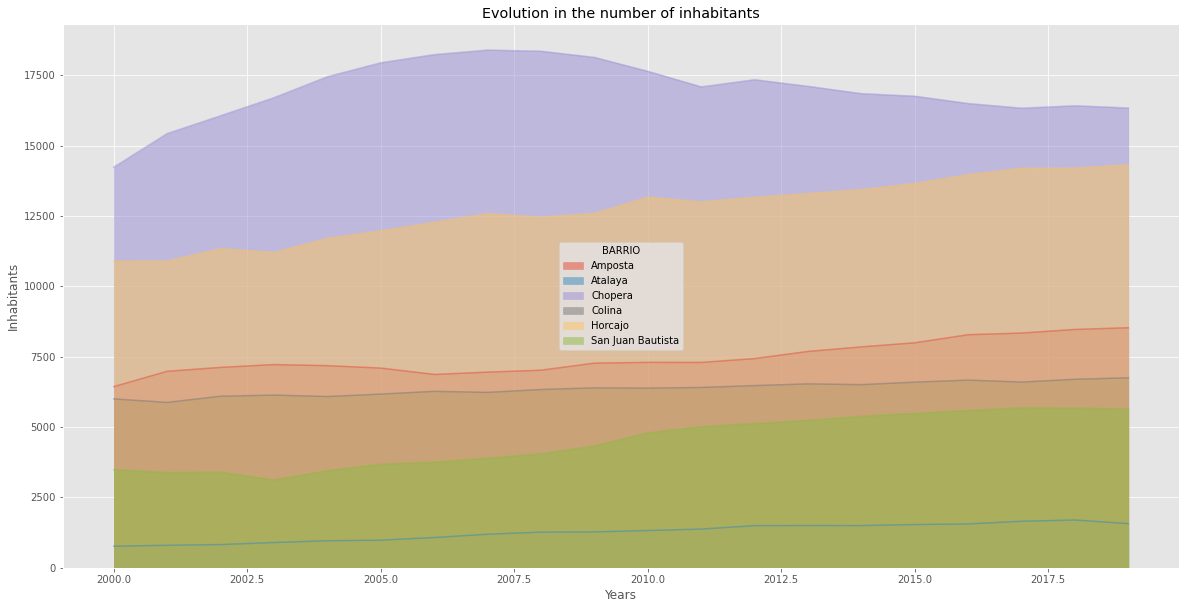

In [129]:
madrid_final_grow.index = madrid_final_grow.index.map(int)
madrid_final_grow.plot(kind='area', stacked=False, figsize=(20, 10),)
plt.title('Evolution in the number of inhabitants')
plt.ylabel('Inhabitants')
plt.xlabel('Years')
plt.show()

So, final decisión, Horcajo.